In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/maclean/code')
sys.path.append('/home/maclean/code/mr_resonator')

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import copy
import scipy.interpolate as interpolate
import pickle



from mr_complex_resonator import MR_complex_resonator as MR_complex_resonator
from mr_lekid import MR_LEKID as MR_LEKID
import utils
from iterators.freq_sweep_iterator import freq_sweep_iterator



colormap = plt.cm.gnuplot
colormap2 = plt.cm.viridis
colormap3 = plt.cm.turbo
colormap4 = plt.cm.summer_r


def to_dbm(x):
    return 10*np.log10(1e3*x)

def to_W(x):
    return 10**(x/10.) * 1e-3


plt.rcParams.update({'xtick.labelsize' : '18'})
plt.rcParams.update({'ytick.labelsize' : '18'})
plt.rcParams.update({'legend.fontsize' : '13'})
plt.rcParams.update({'font.size' : '18'})
plt.rcParams.update({'axes.formatter.useoffset' : 'False'})
plt.rcParams['axes.grid'] = True

# demo implementation of the electrothermal nonlinearity, as it presents during probe frequency sweeps


for simplicity --- and to avoid having to figure out the dynamics of the electrothermal aspect --- let's just do the steady state version. This means that as we sweep the probe across the resonator, at each frequency step we iterate the impedance and current until we reach stable values. Then move on to the next probe frequency.

We'll use goldie&withington's numerical approximation (Eq 13 in https://iopscience.iop.org/article/10.1088/0953-2048/26/1/015004/pdf) to compute the effective qp distribution temperature, and use that the update the nqp AND complex conductivity directly since it is dependent on T 


Some to-dos and open questions:
- is it physically valid to compute the complex conductivity in this regime, given the approximations needed to obtain these expressions from the mattis-bardeen integrals? Eg Eqs 16 & 17 in https://link.springer.com/article/10.1007/s10909-007-9688-z
- I'm using a scaling factor to adjust the strength of the electrothermal nonlinearity, but this is arbitrary. Not sure how to obtain a realistic value for $\Sigma_s$
- right now the iterator basically just runs for n cycles (generally it converges in << n), but I'm working on adding some convergence checks to make this more efficient





## sketch out a resonator like the one shown in vaskuri et al 2025

comparing with the optical power response in fig 3

L_total = 2.64e-08
fr = 1.09e+09
Qr: 1.71e+04, Qi: 8.33e+04, Qc: 2.15e+04
Qr: 1.09e+04, Qi: 2.20e+04, Qc: 2.15e+04
Qr: 5.26e+03, Qi: 6.96e+03, Qc: 2.15e+04
Qr: 2.72e+03, Qi: 3.11e+03, Qc: 2.15e+04


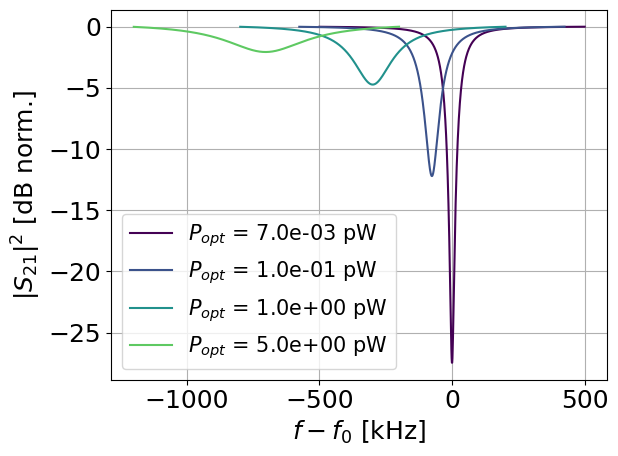

In [4]:


Popt = 7e-15 # dark conditions from the paper
T=0.1

# inductor geometry from vaskuri et al 2025
width = 0.8e-6
thickness = 30e-9
VL = 440e-18
Rs = 0.7 # measured for the SLIM 30 nm Al LEKIDs -- produces total L as in vaskuri et al
rho_N = Rs * thickness
sigmaN = 1./rho_N
alpha_k = 0.7
opt_eff = 0.72


C = 0.8e-12 # choose so that fr is around 1 GHz as in the paper
Cc = 1.5e-14
res_params = dict(T=T, Popt=Popt, 
                 alpha_k=alpha_k, thickness=thickness, width=width, VL=VL,
                 sigmaN=sigmaN, C=C, Cc=Cc, opt_eff=opt_eff)

baseline_res = MR_complex_resonator(**res_params)
fix_Lg = baseline_res.Lg
res_params['fix_Lg'] = fix_Lg

fr0 = baseline_res.lekid.compute_fr()

print('L_total = %.2e'%(baseline_res.lekid.Lk + baseline_res.lekid.Lg))
print('fr = %.2e'%(fr0))

Prange = [7e-15, 1e-13, 1e-12, 5e-12]
for p, Popt in enumerate(Prange):

    plotcolour = colormap2(float(p) / len(Prange))
    res_params['Popt'] = Popt
    res = MR_complex_resonator(**res_params)
    fr = res.lekid.compute_fr()
    span = 500e3
    frange = np.linspace(fr-span, fr+span, 1000)
    Vout = res.lekid.compute_Vout(frange)
    
    plotfreq = 1e-3*(frange - fr0)
    mag_db_sq = 20*np.log10(abs(Vout)**2 / abs(Vout[-1])**2) # for some reason this is squared in the paper
    plt.plot(plotfreq, mag_db_sq, color=plotcolour, label='$P_{opt}$ = %.1e pW'%(1e12*Popt))
    
    Qr, Qi, Qc = res.lekid.fit_for_Q_values()
    print('Qr: %.2e, Qi: %.2e, Qc: %.2e'%(Qr, Qi, Qc))

plt.ylabel('$|S_{21}|^2$ [dB norm.]')
plt.xlabel('$f - f_0$ [kHz]')
plt.legend()


close enough!

## example sweep simulations with nonlinearity

### sweep at various probe amplitude levels


note: adjust the n_sweep_pts for higher resolution in the sweep but at the cost of slower compute

#### at lower optical load

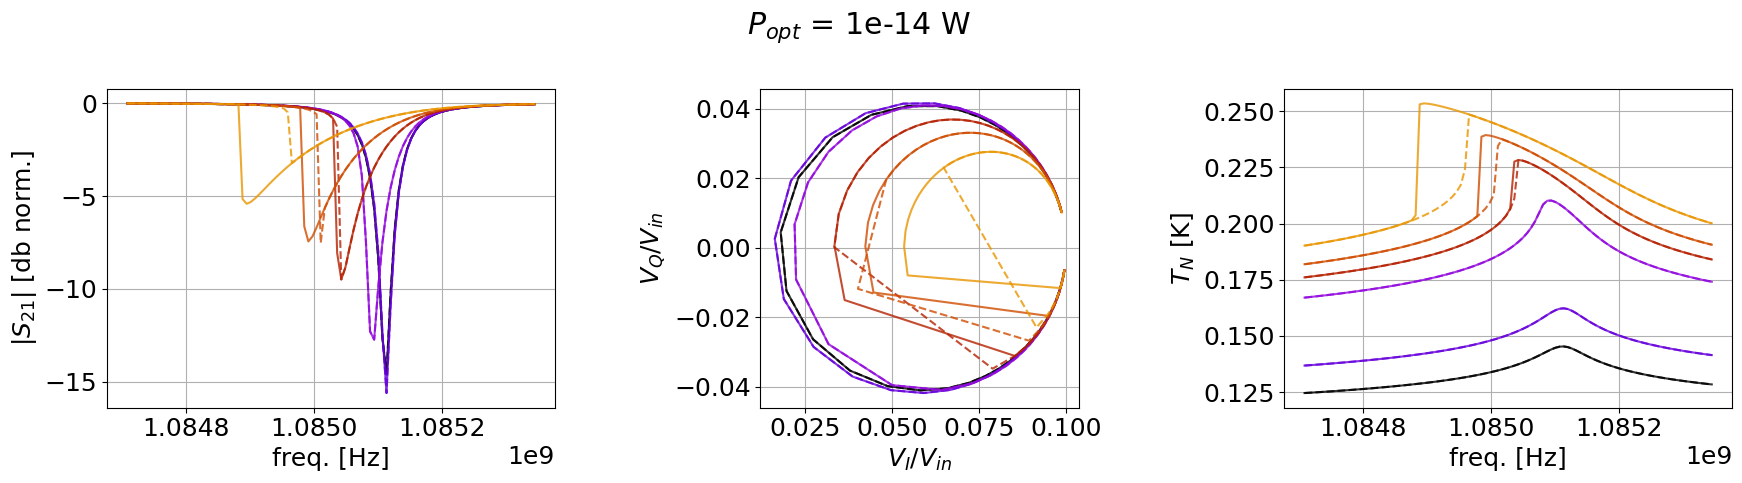

In [6]:
nplots = 3
fig = plt.figure(figsize=(nplots*6, 5))
axarr = []
for x in range(nplots):
    ax = fig.add_subplot(1, nplots, x+1)
    axarr.append(ax)


n_sweep_pts = 100
direction = 'UP'
big_sigma_factor = 1e5

Vin_range = [1e-6, 0.5e-5, 1e-4, 2e-4, 3e-4, 5e-4]

Popt = 1e-14

for v, Vin in enumerate(Vin_range):
    plotcolour = colormap(float(v) / len(Vin_range))
    
    # create the resonator 
    res_params['Popt'] = Popt
    res_params['Vin'] = Vin
    res_params['big_sigma_factor'] = big_sigma_factor
    res = MR_complex_resonator(**res_params)
    
    fr = res.lekid.compute_fr()
    sweep_span = 400e3
    trim_upper = 1.7
    # sweep_frange = np.linspace(fr-sweep_span, fr+sweep_span, n_sweep_pts)
    for direction in ['UP', 'DOWN']:
        if direction =='UP':
            linestyle='--'
            sweep_frange = np.linspace(fr-sweep_span, fr+sweep_span//trim_upper, n_sweep_pts)
        else:
            linestyle = '-'
            sweep_frange = np.linspace(fr+sweep_span//trim_upper, fr-sweep_span, n_sweep_pts)
        outdict = freq_sweep_iterator(res=copy.deepcopy(res), sweep_frange=sweep_frange,
                                  niters=100)
        
        steps = sorted(outdict.keys())
        probe_freq = np.asarray([outdict[step]['probe_freq']['final'] for step in steps])
        probe_Vout = np.asarray([outdict[step]['probe_Vout']['final'] for step in steps])
        # passed = np.asarray([outdict[step]['TN_passed']['iters'] for step in steps])
        TN = np.asarray([outdict[step]['TN']['final'] for step in steps])
        Pabs = np.asarray([outdict[step]['Pabs']['final'] for step in steps])
        Ires = np.asarray([outdict[step]['Ires']['final'] for step in steps])
        Pabs = np.asarray([outdict[step]['Pabs']['final'] for step in steps])
        # print(passed)

        Vref = probe_Vout[probe_freq.argmin()]
        mag_db = 20*np.log10(abs(probe_Vout) / abs(Vref))
        axarr[0].plot(probe_freq, mag_db, linestyle, alpha=0.8, color=plotcolour)
        axarr[1].plot(probe_Vout.real/Vin, probe_Vout.imag/Vin, linestyle, alpha=0.8, color=plotcolour)
    
        # print(TN)
        axarr[2].plot(probe_freq, TN, linestyle, alpha=0.8, color=plotcolour)

axarr[0].set_ylabel('$|S_{21}|$ [db norm.]')
axarr[0].set_xlabel('freq. [Hz]')
axarr[2].set_xlabel('freq. [Hz]')
axarr[2].set_ylabel('$T_N$ [K]')

axarr[1].set_ylabel('$V_Q / V_{in}$')
axarr[1].set_xlabel('$V_I / V_{in}$')

utils.square_axes(axarr[1])

fig.suptitle('$P_{opt}$ = %.0e W'%Popt)
fig.tight_layout()

### at higher optical load

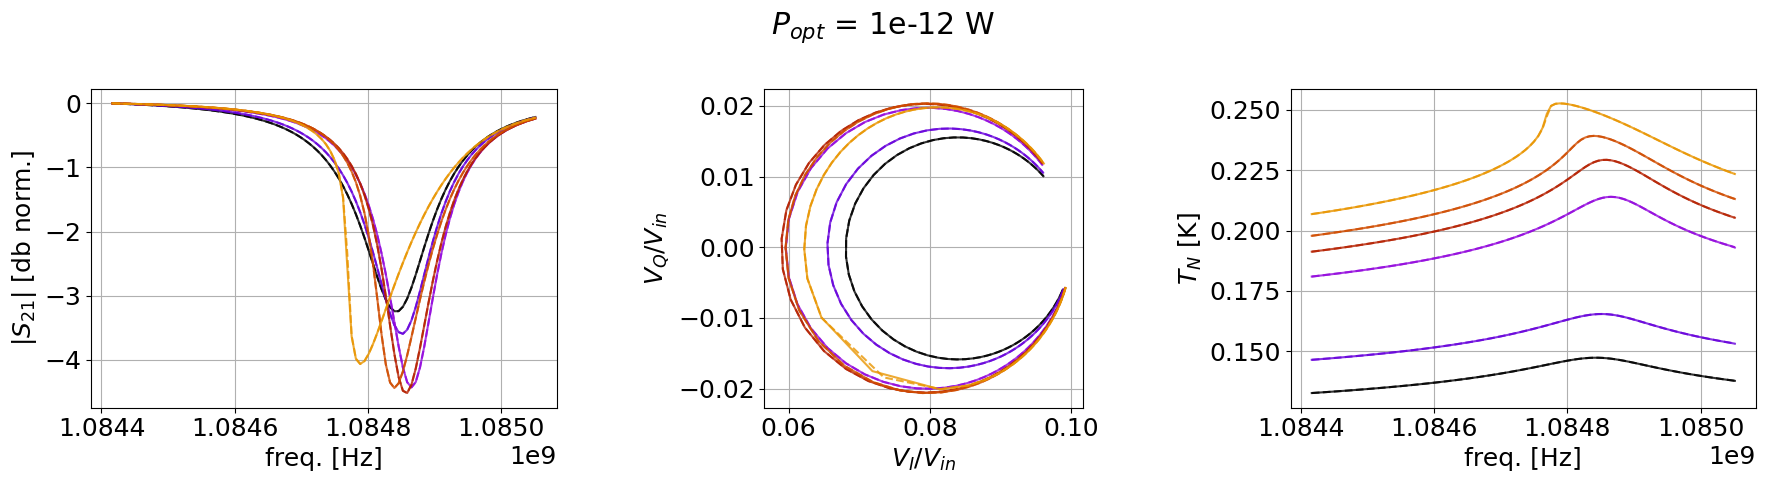

In [7]:
nplots = 3
fig = plt.figure(figsize=(nplots*6, 5))
axarr = []
for x in range(nplots):
    ax = fig.add_subplot(1, nplots, x+1)
    axarr.append(ax)


n_sweep_pts = 100
direction = 'UP'
big_sigma_factor = 1e5

Vin_range = [1e-6, 0.5e-5, 1e-4, 2e-4, 3e-4, 5e-4]

Popt = 1e-12

for v, Vin in enumerate(Vin_range):
    plotcolour = colormap(float(v) / len(Vin_range))
    
    # create the resonator 
    res_params['Popt'] = Popt
    res_params['Vin'] = Vin
    res_params['big_sigma_factor'] = big_sigma_factor
    res = MR_complex_resonator(**res_params)
    
    fr = res.lekid.compute_fr()
    sweep_span = 400e3
    trim_upper = 1.7
    # sweep_frange = np.linspace(fr-sweep_span, fr+sweep_span, n_sweep_pts)
    for direction in ['UP', 'DOWN']:
        if direction =='UP':
            linestyle='--'
            sweep_frange = np.linspace(fr-sweep_span, fr+sweep_span//trim_upper, n_sweep_pts)
        else:
            linestyle = '-'
            sweep_frange = np.linspace(fr+sweep_span//trim_upper, fr-sweep_span, n_sweep_pts)
        outdict = freq_sweep_iterator(res=copy.deepcopy(res), sweep_frange=sweep_frange,
                                  niters=100)
        
        steps = sorted(outdict.keys())
        probe_freq = np.asarray([outdict[step]['probe_freq']['final'] for step in steps])
        probe_Vout = np.asarray([outdict[step]['probe_Vout']['final'] for step in steps])
        # passed = np.asarray([outdict[step]['TN_passed']['iters'] for step in steps])
        TN = np.asarray([outdict[step]['TN']['final'] for step in steps])
        Pabs = np.asarray([outdict[step]['Pabs']['final'] for step in steps])
        Ires = np.asarray([outdict[step]['Ires']['final'] for step in steps])
        Pabs = np.asarray([outdict[step]['Pabs']['final'] for step in steps])
        # print(passed)

        Vref = probe_Vout[probe_freq.argmin()]
        mag_db = 20*np.log10(abs(probe_Vout) / abs(Vref))
        axarr[0].plot(probe_freq, mag_db, linestyle, alpha=0.8, color=plotcolour)
        axarr[1].plot(probe_Vout.real/Vin, probe_Vout.imag/Vin, linestyle, alpha=0.8, color=plotcolour)
    
        # print(TN)
        axarr[2].plot(probe_freq, TN, linestyle, alpha=0.8, color=plotcolour)

axarr[0].set_ylabel('$|S_{21}|$ [db norm.]')
axarr[0].set_xlabel('freq. [Hz]')
axarr[2].set_xlabel('freq. [Hz]')
axarr[2].set_ylabel('$T_N$ [K]')

axarr[1].set_ylabel('$V_Q / V_{in}$')
axarr[1].set_xlabel('$V_I / V_{in}$')

utils.square_axes(axarr[1])

fig.suptitle('$P_{opt}$ = %.0e W'%Popt)
fig.tight_layout()